In [17]:
import pandas as pd
import numpy as np
import re

file_name = 'task2.csv'

try:
    df = pd.read_csv(file_name, encoding='latin1', engine='python')
except Exception as e:
    print(f"Error with engine='python': {e}. Falling back to on_bad_lines='skip'...")
    df = pd.read_csv(file_name, encoding='latin1', on_bad_lines='skip')

print(f"Successfully loaded data from '{file_name}'. Shape: {df.shape}")
print("-" * 30)

df_cleaned = df.copy()
df_cleaned.columns = [col.lower().strip().replace(' ', '_') for col in df_cleaned.columns]
print("Column names standardized to snake_case.")

def clean_text(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\\', '', text)
    text = re.sub(r'[\n\t]+', ' ', text)
    text = text.replace('  ', 'unknown_encoding_error')
    text = text.lower().strip()
    text = re.sub(r'\\', '', text)
    return text

text_cols_to_clean = [
    'correction_verbatim', 
    'customer_verbatim', 
    'engine_desc', 
    'transmission_desc',
    'causal_part_nm',
    'global_labor_code_description'
]

for col in text_cols_to_clean:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].apply(clean_text)

print("Text cleaning complete.")
print("Correcting data types...")

if 'repair_date' in df_cleaned.columns:
    df_cleaned['repair_date'] = pd.to_datetime(df_cleaned['repair_date'], errors='coerce')

numeric_cols = ['repair_age', 'km', 'reporting_cost', 'totalcost', 'lbrcost']
for col in numeric_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print("Data types corrected. Any conversion errors are marked as NaN/NaT.")
print("Checking for rows with more than 5 missing values...")

rows_before = df_cleaned.shape[0]
total_cols = df_cleaned.shape[1]
min_non_null = total_cols - 5
df_cleaned = df_cleaned.dropna(thresh=min_non_null)

rows_after = df_cleaned.shape[0]
print(f"Dropped {rows_before - rows_after} rows for having more than 5 missing values.")
print(f"New shape before imputation: {df_cleaned.shape}")

print("Attempting to fill remaining missing values...")

for col in numeric_cols:
    if col in df_cleaned.columns:
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)
        print(f"Numeric gaps in '{col}' filled with median: {median_val}")

for col in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[col] = df_cleaned[col].fillna('Unknown')

print("All text gaps filled with 'Unknown'.")
print("Imputation step complete.")

print("Identifying and handling outliers...")

outlier_check_cols = ['km', 'totalcost', 'lbrcost']

for col in outlier_check_cols:
    if col in df_cleaned.columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = df_cleaned[
            (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
        ].shape[0]
        print(f"'{col}': Found {outlier_count} potential outliers (values < {lower_bound:.2f} or > {upper_bound:.2f})")
        p01 = df_cleaned[col].quantile(0.01)
        p99 = df_cleaned[col].quantile(0.99)
        df_cleaned[col] = np.clip(df_cleaned[col], p01, p99)
        print(f"Capped '{col}' at 1st percentile ({p01:.2f}) and 99th percentile ({p99:.2f}).")

print("Outlier handling complete.")
print("Standardizing categorical values...")

if 'causal_part_nm' in df_cleaned.columns:
    df_cleaned['causal_part_nm'] = df_cleaned['causal_part_nm'].replace(
        'wheel asm-strg *backen blackk', 'wheel asm-strg *black'
    )
    consolidation_map = {
        'wheel asm-strg *jet black': 'wheel asm-strg *black',
        '"wheel,strg *jet black"': 'wheel asm-strg *black',
        'wheel asm-strg *very dark at': 'wheel asm-strg *very dark atmosphere',
        'wheel asm-strg *dark titaniu': 'wheel asm-strg *dark titanium'
    }
    df_cleaned['causal_part_nm'] = df_cleaned['causal_part_nm'].replace(consolidation_map)
    print(f"Unique 'black' steering wheel parts after: {df_cleaned[df_cleaned['causal_part_nm'].str.contains('black')]['causal_part_nm'].nunique()}")
    print("Categorical standardization complete.")
else:
    print("'causal_part_nm' column not found, skipping standardization.")

print("\n" + "=" * 30)
print("Data Cleaning Complete. Final DataFrame Info:")
df_cleaned.info()

file_name = 'cleaned_vehicle_repairs_Cleaned.csv'
df_cleaned.to_csv(file_name, index=False, encoding='utf-8')

print("\n" + "=" * 30)
print(f"Successfully saved cleaned data to '{file_name}'")


Successfully loaded data from 'task2.csv'. Shape: (100, 52)
------------------------------
Column names standardized to snake_case.
Text cleaning complete.
Correcting data types...
Data types corrected. Any conversion errors are marked as NaN/NaT.
Checking for rows with more than 5 missing values...
Dropped 13 rows for having more than 5 missing values.
New shape before imputation: (87, 52)
Attempting to fill remaining missing values...
Numeric gaps in 'repair_age' filled with median: 12.0
Numeric gaps in 'km' filled with median: 252.5
Numeric gaps in 'reporting_cost' filled with median: 411.91
Numeric gaps in 'totalcost' filled with median: 435.26
Numeric gaps in 'lbrcost' filled with median: 74.99
All text gaps filled with 'Unknown'.
Imputation step complete.
Identifying and handling outliers...
'km': Found 8 potential outliers (values < 252.50 or > 252.50)
Capped 'km' at 1st percentile (7.30) and 99th percentile (719.26).
'totalcost': Found 9 potential outliers (values < 122.74 or >

Loading cleaned data from: cleaned_vehicle_repairs_Cleaned.csv
Data loaded successfully. Generating visualizations...
Saved: 'top_repair_types.png'
Saved: 'repairs_by_platform.png'
Saved: 'cost_distribution.png'

Analysis complete. All charts have been saved as .png files.


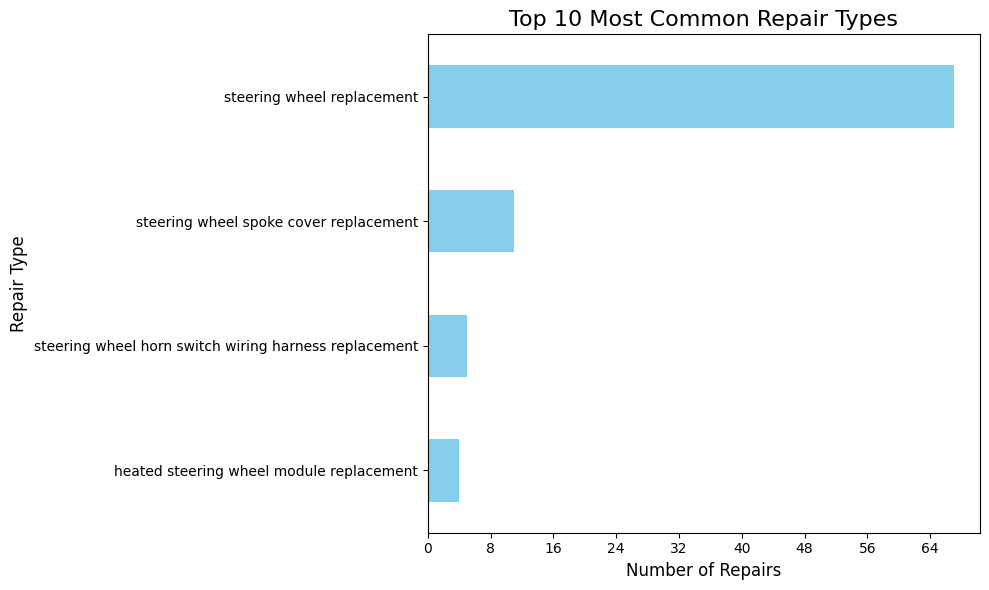

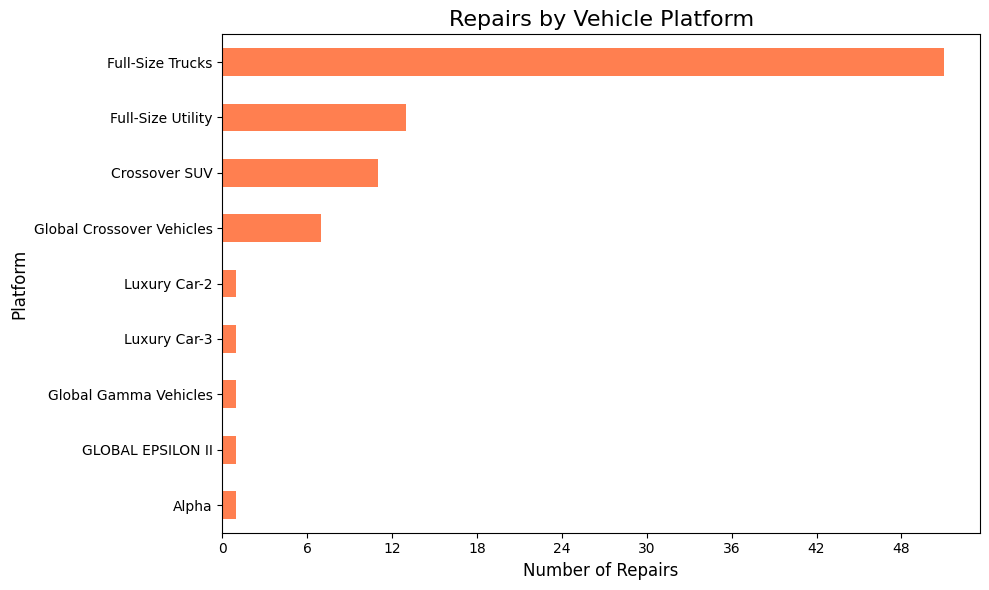

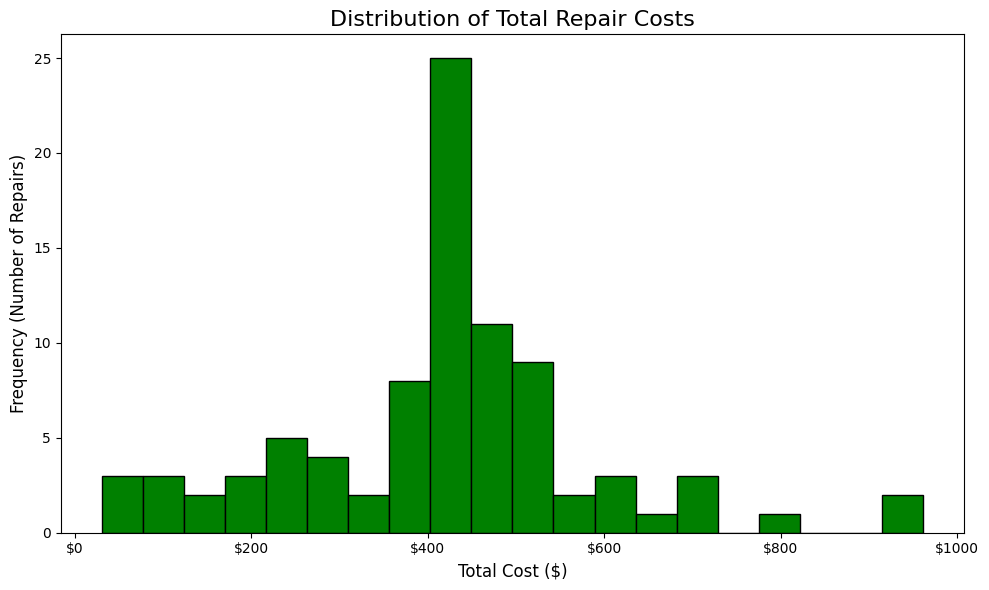

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
import pandas as pd

def analyze_repairs(file_name):
    print(f"Loading cleaned data from: {file_name}")
    try:
        df = pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
        print("Please make sure this script is in the same folder as the CSV file.")
        return
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return

    print("Data loaded successfully. Generating visualizations...")

    repair_counts = df['global_labor_code_description'].value_counts()
    top_n = 10
    repair_counts_top = repair_counts.head(top_n)

    plt.figure(figsize=(10, 6))
    repair_counts_top.sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title(f'Top {top_n} Most Common Repair Types', fontsize=16)
    plt.xlabel('Number of Repairs', fontsize=12)
    plt.ylabel('Repair Type', fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.tight_layout()
    output_png_1 = 'top_repair_types.png'
    plt.savefig(output_png_1)
    print(f"Saved: '{output_png_1}'")

    platform_counts = df['platform'].value_counts()
    plt.figure(figsize=(10, 6))
    platform_counts.sort_values(ascending=True).plot(kind='barh', color='coral')
    plt.title('Repairs by Vehicle Platform', fontsize=16)
    plt.xlabel('Number of Repairs', fontsize=12)
    plt.ylabel('Platform', fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.tight_layout()
    output_png_2 = 'repairs_by_platform.png'
    plt.savefig(output_png_2)
    print(f"Saved: '{output_png_2}'")

    plt.figure(figsize=(10, 6))
    if 'totalcost' in df.columns:
        df['totalcost'].plot(kind='hist', bins=20, color='green', edgecolor='black')
        plt.title('Distribution of Total Repair Costs', fontsize=16)
        plt.xlabel('Total Cost ($)', fontsize=12)
        plt.ylabel('Frequency (Number of Repairs)', fontsize=12)
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('$%1.0f'))
        plt.tight_layout()
        output_png_3 = 'cost_distribution.png'
        plt.savefig(output_png_3)
        print(f"Saved: '{output_png_3}'")
    else:
        print("Warning: 'totalcost' column not found. Skipping cost distribution chart.")

    print("\nAnalysis complete. All charts have been saved as .png files.")

if __name__ == "__main__":
    cleaned_file = 'cleaned_vehicle_repairs_Cleaned.csv'
    analyze_repairs(cleaned_file)


In [20]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer

file_name = 'task2.csv'
print(f"Loading data from '{file_name}'...")

try:
    df = pd.read_csv(file_name, encoding='latin1', engine='python')
except Exception as e:
    print(f"Error with engine='python': {e}. Falling back to on_bad_lines='skip'...")
    df = pd.read_csv(file_name, encoding='latin1', on_bad_lines='skip')

print(f"Successfully loaded data. Shape: {df.shape}")
print("-" * 30)

df_cleaned = df.copy()
df_cleaned.columns = [col.lower().strip().replace(' ', '_') for col in df_cleaned.columns]
print("Column names standardized to snake_case.")

print("Cleaning text columns...")

def clean_text(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\\', '', text)
    text = re.sub(r'[\n\t]+', ' ', text)
    text = text.replace('  ', 'unknown_encoding_error')
    text = text.lower().strip()
    text = re.sub(r'\\', '', text)
    return text

text_cols_to_clean = [
    'correction_verbatim', 'customer_verbatim', 'engine_desc',
    'transmission_desc', 'causal_part_nm', 'global_labor_code_description'
]

for col in text_cols_to_clean:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].apply(clean_text)

print("Text cleaning complete.")

print("Correcting data types...")

if 'repair_date' in df_cleaned.columns:
    df_cleaned['repair_date'] = pd.to_datetime(df_cleaned['repair_date'], errors='coerce')

numeric_cols = ['repair_age', 'km', 'reporting_cost', 'totalcost', 'lbrcost']
for col in numeric_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print("Data types corrected. Conversion errors are now NaN/NaT.")

print("Dropping rows with more than 5 missing values...")
rows_before = df_cleaned.shape[0]
total_cols = df_cleaned.shape[1]
min_non_null = total_cols - 5
df_cleaned = df_cleaned.dropna(thresh=min_non_null)
rows_after = df_cleaned.shape[0]
print(f"Dropped {rows_before - rows_after} rows for having more than 5 missing values.")

print("Attempting to fill remaining missing values...")

for col in numeric_cols:
    if col in df_cleaned.columns:
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)

for col in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[col] = df_cleaned[col].fillna('Unknown')

print("Imputation step complete.")

print("Identifying and handling outliers...")
outlier_check_cols = ['km', 'totalcost', 'lbrcost']

for col in outlier_check_cols:
    if col in df_cleaned.columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = df_cleaned[
            (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
        ].shape[0]
        print(f"'{col}': Found {outlier_count} potential outliers.")
        p01 = df_cleaned[col].quantile(0.01)
        p99 = df_cleaned[col].quantile(0.99)
        df_cleaned[col] = np.clip(df_cleaned[col], p01, p99)
        print(f"Capped '{col}' at 1st percentile ({p01:.2f}) and 99th percentile ({p99:.2f}).")

print("Outlier handling complete.")

print("Standardizing categorical values...")

if 'causal_part_nm' in df_cleaned.columns:
    df_cleaned['causal_part_nm'] = df_cleaned['causal_part_nm'].replace(
        'wheel asm-strg *backen blackk', 'wheel asm-strg *black'
    )
    consolidation_map = {
        'wheel asm-strg *jet black': 'wheel asm-strg *black',
        '"wheel,strg *jet black"': 'wheel asm-strg *black',
        'wheel asm-strg *very dark at': 'wheel asm-strg *very dark atmosphere',
        'wheel asm-strg *dark titaniu': 'wheel asm-strg *dark titanium'
    }
    df_cleaned['causal_part_nm'] = df_cleaned['causal_part_nm'].replace(consolidation_map)
    print("Categorical standardization complete.")
else:
    print("'causal_part_nm' column not found, skipping standardization.")

print("\n" + "=" * 30)
print("Starting NLP Tag Generation (TF-IDF)...")

df_cleaned['customer_verbatim'] = df_cleaned['customer_verbatim'].astype(str).fillna('')
df_cleaned['correction_verbatim'] = df_cleaned['correction_verbatim'].astype(str).fillna('')
df_cleaned['nlp_corpus'] = df_cleaned['customer_verbatim'] + ' ' + df_cleaned['correction_verbatim']

vectorizer = TfidfVectorizer(stop_words='english', max_features=30, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(df_cleaned['nlp_corpus'])
nlp_tags_raw = vectorizer.get_feature_names_out()

df_tags_binary = pd.DataFrame(tfidf_matrix.toarray(), columns=nlp_tags_raw)
df_tags_binary = (df_tags_binary > 0).astype(int)

print(f"Generated {len(nlp_tags_raw)} tags dynamically using NLP.")

print("Consolidating NLP tags into a single column...")

def join_nlp_tags(row):
    active_tags = row[row == 1].index.tolist()
    return ', '.join(active_tags)

nlp_tags_consolidated = df_tags_binary.apply(join_nlp_tags, axis=1)
df_cleaned['nlp_tags_consolidated'] = nlp_tags_consolidated

print("Consolidated NLP tag column created.")

print("\n" + "=" * 30)
print("Filtering DataFrame to include only transaction_id and consolidated NLP tags...")

final_cols_to_save = []
if 'transaction_id' in df_cleaned.columns:
    final_cols_to_save.append('transaction_id')
else:
    print("Warning: 'transaction_id' column not found.")

final_cols_to_save.append('nlp_tags_consolidated')
existing_cols = [col for col in final_cols_to_save if col in df_cleaned.columns]
df_final_output = df_cleaned[existing_cols].copy()

print("Sample of Final Output Data:")
print(df_final_output.head(10))

output_file_name = 'transaction_id_with_consolidated_nlp_tags.csv'
df_final_output.to_csv(output_file_name, index=False, encoding='utf-8')

print("\n" + "=" * 30)
print(f"Successfully saved final data to: {output_file_name}")


Loading data from 'task2.csv'...
Successfully loaded data. Shape: (100, 52)
------------------------------
Column names standardized to snake_case.
Cleaning text columns...
Text cleaning complete.
Correcting data types...
Data types corrected. Conversion errors are now NaN/NaT.
Dropping rows with more than 5 missing values...
Dropped 13 rows for having more than 5 missing values.
Attempting to fill remaining missing values...
Imputation step complete.
Identifying and handling outliers...
'km': Found 8 potential outliers.
Capped 'km' at 1st percentile (7.30) and 99th percentile (719.26).
'totalcost': Found 9 potential outliers.
Capped 'totalcost' at 1st percentile (31.05) and 99th percentile (961.30).
'lbrcost': Found 8 potential outliers.
Capped 'lbrcost' at 1st percentile (27.02) and 99th percentile (353.95).
Outlier handling complete.
Standardizing categorical values...
Categorical standardization complete.

Starting NLP Tag Generation (TF-IDF)...
Generated 30 tags dynamically using 